## Comparing male and female read depths per contig to identify X and or Y specific contigs in the G. wheatlandi assembly

I have aligned short read data from 35 samples (24 males, 9 females) to the blackspotted draft assembly. This assembly has already had some reads removed before assembly, which should be male specific. 

I marked duplicates and then counted coverage per 1kb window (using RPKM normalisation). I now need to average the coverage per contig for males and females. I'm looking for contigs with relative coverages in males and females indicative of different copy numbers. 

Specifically, X specific contigs should have 2n coverage in females (i.e. close to the genome average) and 1n coverage in males. And though there shouldn't be many in there, Y specific scaffolds should have 1n coverage in males and basically 0 coverage in females.

On the cluster I averaged the coverages per bin across each contig for each species and combined this into a single file, with one line per contig and one column per sample. I also added the contig lengths into this file. 


### Lets have a quick look at the contig lengths first ...

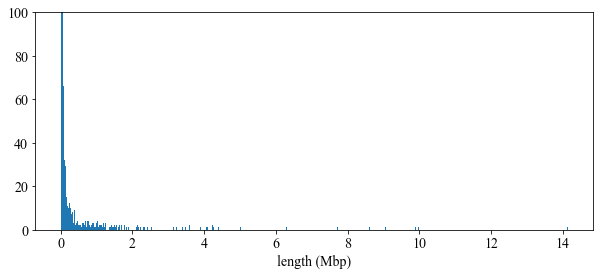

In [41]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})

with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/contigs.bed") as cont_lengths:
    lengths = []
    for line in cont_lengths:
        lengths.append(int(line.split()[2])/1000000)
        
fig = plt.figure(figsize = (10,4))

plt.hist(lengths, bins = 1000)
plt.xlabel("length (Mbp)")
plt.ylim(0,100)
plt.show()


In [3]:
import numpy as np

with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/All_contig_avgs.txt") as All_contig_covs:
    
    contig_dict = {}
    
    M_indices = []
    F_indices = []
    
    for line in All_contig_covs:
        
        if line.startswith("Contig"):
            samples = line.split()[1:]
            
            sample_index = 0
            
            for sample in samples:
                if "_F" in sample:
                    F_indices.append(sample_index)
                elif "_M" in sample:
                    M_indices.append(sample_index)
                
                sample_index += 1
            
        else:
            contig = line.split()[0]
            contig_dict[contig] = {}
            contig_dict[contig]["males"] = []
            contig_dict[contig]["females"] = []
            
            data_fields = line.split()[1:]
            
            for index in range(0,34):
                if index in M_indices:
                    contig_dict[contig]["males"].append(float(data_fields[index]))
                elif index in F_indices:
                    contig_dict[contig]["females"].append(float(data_fields[index]))
                    
contig_avgs = {}

for contig in contig_dict:
    
    contig_avgs[contig] = {}
    contig_avgs[contig]["male"] = np.mean(contig_dict[contig]["males"])
    contig_avgs[contig]["female"] = np.mean(contig_dict[contig]["females"])
                

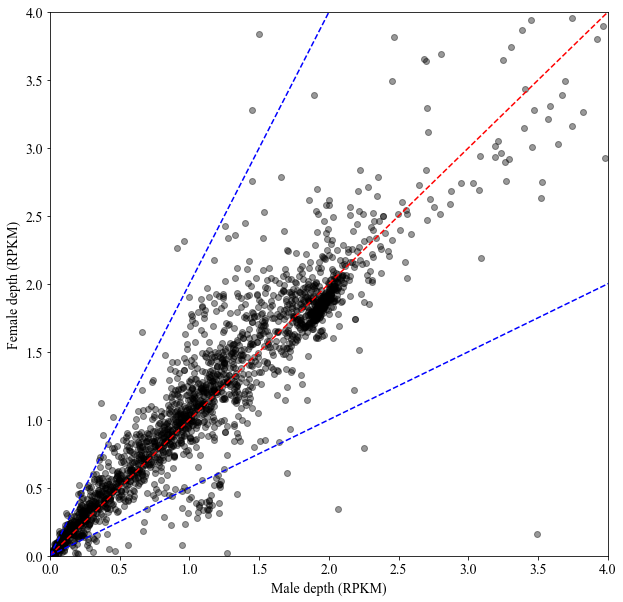

In [42]:

plt.figure(figsize = (10,10))

for contig in contig_avgs:
    
    plt.scatter(contig_avgs[contig]["male"], contig_avgs[contig]["female"], color = "black", alpha = 0.4)
    
plt.plot(range(0,10), range(0,10), color = "red", linestyle = "dashed")

plt.plot(range(0,10), [i/2 for i in range(0,10)], color = "blue", linestyle = "dashed")
plt.plot([i/2 for i in range(0,10)], range(0,10), color = "blue", linestyle = "dashed")
    
plt.xlim(0,4)
plt.ylim(0,4)

plt.xlabel("Male depth (RPKM)")
plt.ylabel("Female depth (RPKM)")

plt.show()

This looks weird, so I'm going to check individual coverage at the set of contigs that show the low female vs male read depth. I am just making sure that all samples agree on their RPKM values, and that the means plotted above are not hiding anything weird. 

In [8]:
for contig in contig_avgs:
    if all([1.0 < contig_avgs[contig]["male"] < 1.5, 0.2 < contig_avgs[contig]["female"] < 0.5]):
        print(contig)

contig_135
contig_143
contig_157
contig_159
contig_1721
contig_192
contig_193
contig_200
contig_211
contig_234
contig_235
contig_266
contig_3728
contig_4021
contig_437
contig_519
contig_581
contig_582
contig_584
contig_67
contig_8


In [13]:
print(contig_dict["contig_8"]["males"])
print(contig_dict["contig_8"]["females"])

[1.0696865785714287, 1.0445217795698925, 0.7569951653571428, 0.9077942110912344, 1.1717998007117438, 1.1584771037567083, 1.1599098985765124, 1.158826959074733, 1.1758130301953817, 1.2266078472468918, 1.1610299660107333, 1.1583593548387099, 1.1530685724508047, 1.1671541344086023, 1.157294909090909, 1.1564102259786475, 1.133633754010695, 1.1622983680430878, 1.1784100177619896, 1.1936390090415911, 1.2194084828828828, 0.8668011597802199, 1.2183158418478262, 1.2200338888888889, 0.38358336882591093, 1.1151332251386321]
[0.2878305959245283, 0.325482903974122, 0.30914999678638944, 0.29829246141527, 0.3662585074509804, 0.3647590121900826, 0.37980493701431495, 0.37492470152380947]


Ok it looks like the samples generally agree with eachother within their groups. However, there is no obvious cloud of X-specific regions. One weird thing is that there is a cloud of contigs with female coverage roughly 1/3 of male coverage . . . which doesn't really make sense to me. And I can't think of something that would drive this. 

However, this data is still pretty course, as we are looking at contig wide average depths. Perhaps plotting the same information per bin would be better. . . 

## Per bin (1kb) male vs female depth

For this I combined the deeptools outputs into a single file (using my custom script)

In [317]:
def M_F_bin_coverage(bin_depths_path, colour_contigs = None, colour_bins = None):
    
    from matplotlib import cm
    
    with open(bin_depths_path) as bin_depths:
    
    
        bin_dict = {}
        colour_bin_dict = {}

        M_indices = []
        F_indices = []

        for line in bin_depths:

            if line.startswith("CHROM"):
                samples = line.split()[3:]

                sample_index = 0

                for sample in samples:
                    if "_F" in sample:
                        F_indices.append(sample_index)
                    elif "_M" in sample:
                        M_indices.append(sample_index)

                    sample_index += 1

            else:
                contig = line.split()[0]
                stop = line.split()[2]
                mybin = "%s_%s" % (contig, stop)
                
                bin_dict[mybin] = {}
                bin_dict[mybin]["males"] = []
                bin_dict[mybin]["females"] = []

                data_fields = line.split()[3:]

                for index in range(0,34):
                    if index in M_indices:
                        bin_dict[mybin]["males"].append(float(data_fields[index]))
                    elif index in F_indices:
                        bin_dict[mybin]["females"].append(float(data_fields[index]))
                        
                        
                if colour_contigs:
                    
                    if contig in colour_contigs:
                    
                        colour_bin_dict[mybin] = {}
                        colour_bin_dict[mybin]["males"] = []
                        colour_bin_dict[mybin]["females"] = []

                        data_fields = line.split()[3:]

                        for index in range(0,34):
                            if index in M_indices:
                                colour_bin_dict[mybin]["males"].append(float(data_fields[index]))
                            elif index in F_indices:
                                colour_bin_dict[mybin]["females"].append(float(data_fields[index]))

                        
        bins = []                    
        male_avgs = []
        female_avgs = []


        for mybin in bin_dict:
            bins.append(mybin)
            male_avgs.append(np.mean(bin_dict[mybin]["males"]))
            female_avgs.append(np.mean(bin_dict[mybin]["females"]))

        ## Colour by a list of contigs
        
        if colour_contigs:
            colour_male_avgs = []
            colour_female_avgs = []
            
        if colour_contigs:
            for mybin in colour_bin_dict:
                colour_male_avgs.append(np.mean(bin_dict[mybin]["males"]))
                colour_female_avgs.append(np.mean(bin_dict[mybin]["females"]))

        ## colour by a list of bins
        
        if colour_bins:
            colour_male_avgs_bins = []
            colour_female_avgs_bins = []
            colours = []
            mycols = cm.get_cmap("Oranges")
            
            for mybin in bin_dict:
                if mybin in colour_bins:
                    colour_male_avgs_bins.append(np.mean(bin_dict[mybin]["males"]))
                    colour_female_avgs_bins.append(np.mean(bin_dict[mybin]["females"]))
                    colours.append(mycols(colour_bins[mybin]))
                
                
        plt.figure(figsize = (15,15))

        plt.scatter(male_avgs, female_avgs, color = "black", alpha = 0.01)
        
        if colour_contigs:
            plt.scatter(colour_male_avgs, colour_female_avgs, color = "red", alpha = 0.3)
            
        if colour_bins:
            
            plt.scatter(colour_male_avgs_bins, colour_female_avgs_bins, color = , alpha = 0.3)

        plt.plot(range(0,10), range(0,10), color = "white", linestyle = "dashed")

        ## setting out bins for filtering
        plt.vlines(0.85, 1.4, 2.4, linestyle = "dashed", color = "red", alpha = 0.5)
        plt.vlines(1.25, 1.4, 2.4, linestyle = "dashed", color = "red", alpha = 0.5)
        plt.hlines(1.4, 0.85, 1.25, linestyle = "dashed", color = "red", alpha = 0.5)
        plt.hlines(2.4, 0.85, 1.25, linestyle = "dashed", color = "red", alpha = 0.5)

        plt.vlines(0.7, 0, 0.35, linestyle = "dashed", color = "blue", alpha = 0.5)
        plt.vlines(1.1, 0, 0.35, linestyle = "dashed", color = "blue", alpha = 0.5)
        plt.hlines(0, 0.7, 1.1, linestyle = "dashed", color = "blue", alpha = 0.5)
        plt.hlines(0.35, 0.7, 1.1, linestyle = "dashed", color = "blue", alpha = 0.5)

        plt.xlim(0,4)
        plt.ylim(0,4)

        plt.xlabel("Male depth (RPKM)")
        plt.ylabel("Female depth (RPKM)")

        plt.show()
        
        return bins, male_avgs, female_avgs
    

SyntaxError: invalid syntax (<ipython-input-317-167c04443ce6>, line 109)

In [311]:
from matplotlib import cm
mycols = cm.get_cmap("Oranges")


In [ ]:
M_F_bin_coverage("/home/djeffrie/Data/Stickleback/Y_chrom_comp/Combined_depths.out")

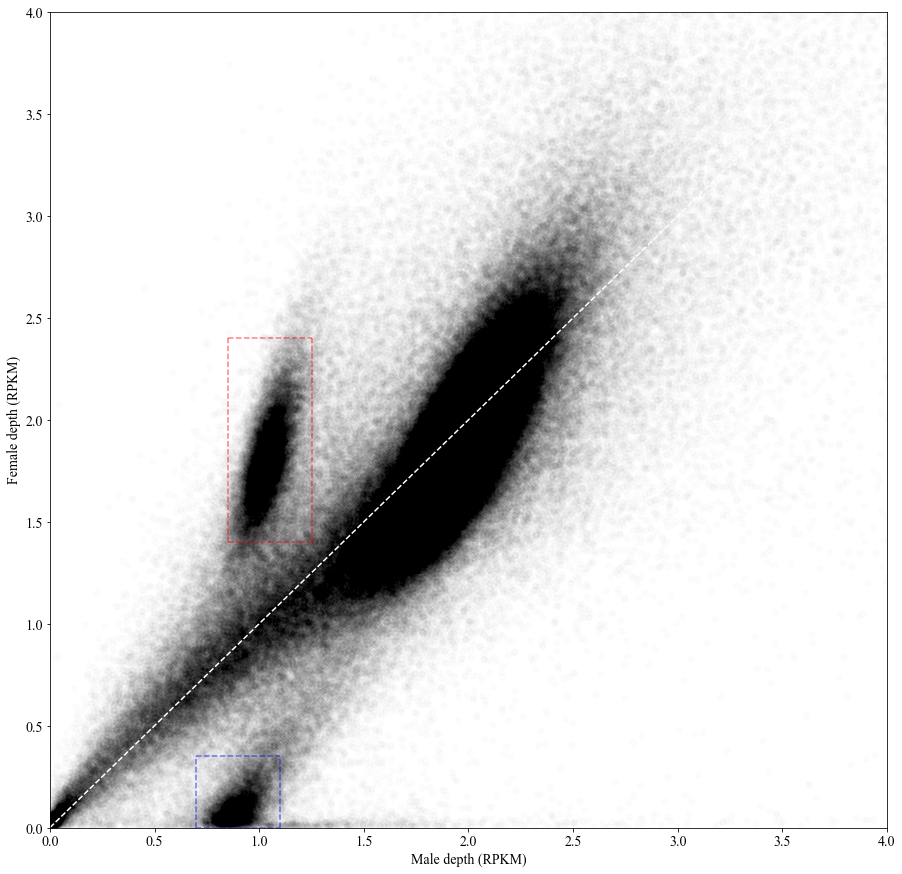

In [111]:
plt.figure(figsize = (15,15))

plt.scatter(male_avgs, female_avgs, color = "black", alpha = 0.01)
    
plt.plot(range(0,10), range(0,10), color = "white", linestyle = "dashed")

## setting out bins for filtering
plt.vlines(0.85, 1.4, 2.4, linestyle = "dashed", color = "red", alpha = 0.5)
plt.vlines(1.25, 1.4, 2.4, linestyle = "dashed", color = "red", alpha = 0.5)
plt.hlines(1.4, 0.85, 1.25, linestyle = "dashed", color = "red", alpha = 0.5)
plt.hlines(2.4, 0.85, 1.25, linestyle = "dashed", color = "red", alpha = 0.5)

plt.vlines(0.7, 0, 0.35, linestyle = "dashed", color = "blue", alpha = 0.5)
plt.vlines(1.1, 0, 0.35, linestyle = "dashed", color = "blue", alpha = 0.5)
plt.hlines(0, 0.7, 1.1, linestyle = "dashed", color = "blue", alpha = 0.5)
plt.hlines(0.35, 0.7, 1.1, linestyle = "dashed", color = "blue", alpha = 0.5)

plt.xlim(0,4)
plt.ylim(0,4)

plt.xlabel("Male depth (RPKM)")
plt.ylabel("Female depth (RPKM)")

plt.show()

Ok, so there are a lot of bins where I would expect for the X specific bins. . . . however there are also quite a few there for what looks like Y specific bins too. The latter is perhaps surprising given that, in theory, we removed a lot of reads that should have been Y specific. 

Next I will assign bins as X or Y specific based on the locations of the clusters above, and then see if I can find contigs to pull out based on what proportion of their length is covered by sex chromosome specific contigs. This is going to be a somewhat arbitrary process, but lets test and see first. 

### X specific bins (red above)

In [112]:
X_spec_bins = []
for i in range(len(bins)):
    if 0.85 < male_avgs[i] < 1.25 and 1.4 < female_avgs[i] < 2.4:
        X_spec_bins.append(bins[i])

### Y specific bins (blue above)

In [113]:
Y_spec_bins = []
for i in range(len(bins)):
    if 0.7 < male_avgs[i] < 1.1 and 0 < female_avgs[i] < 0.35:
        Y_spec_bins.append(bins[i])

## Now plot the proportion of each contig that is made up of sex specific bins

In [130]:
## First count the number of bins in each contig that are sex specific
from collections import Counter
contig_counts = Counter(["_".join(i.split("_")[:2]) for i in X_spec_bins])

## Now get lengths
with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/contigs.bed") as cont_lengths:
    lengths = {}
    for line in cont_lengths:
        lengths[line.split()[0]] = int(line.split()[2])
        
## Now plot proportions
prop_SL_dict = {}

for contig in contig_counts:
    contig_length = lengths[contig]
    prop_SL = (contig_counts[contig])*1000/contig_length
    
    prop_SL_dict[contig] = prop_SL

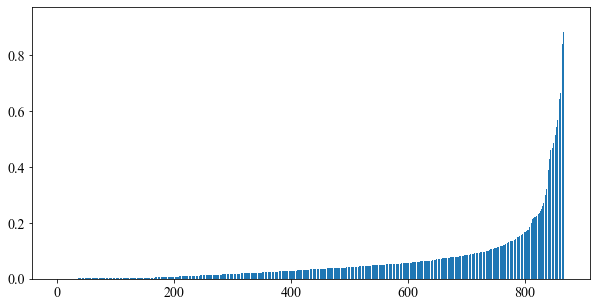

In [135]:
sorted_prop_SL_dict = dict(sorted(prop_SL_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize = (10,5))
plt.bar(range(len(sorted_prop_SL_dict)), sorted_prop_SL_dict.values())
plt.show()
    

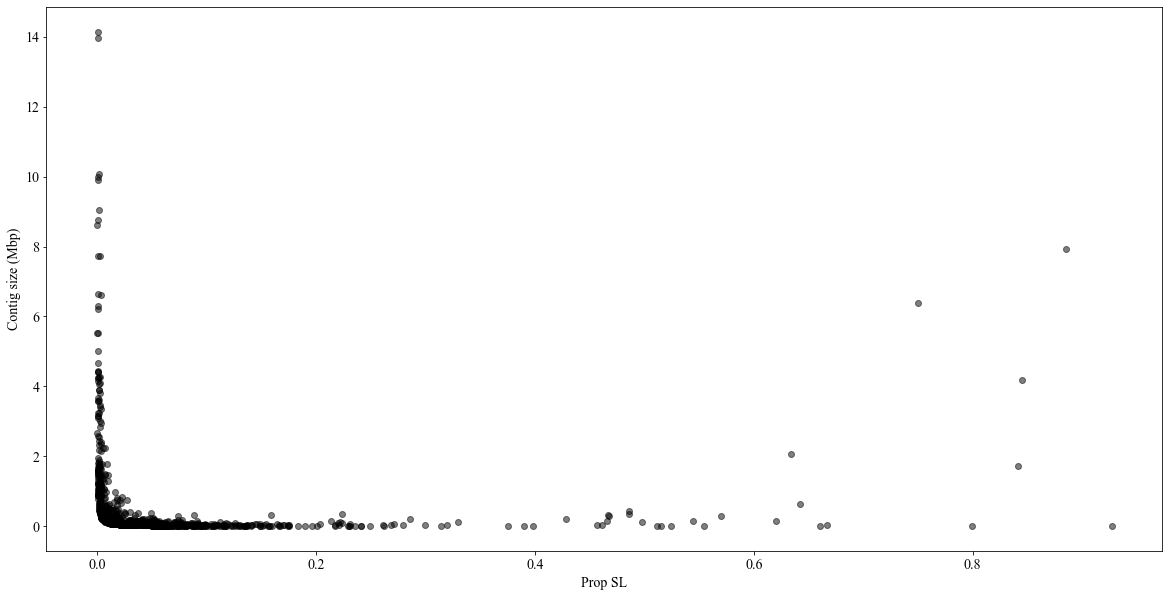

In [146]:
fig = plt.figure(figsize = (20,10))

for contig in sorted_prop_SL_dict:
    
    plt.scatter(sorted_prop_SL_dict[contig], lengths[contig]/1000000, color = "black", alpha = 0.5)
    
plt.xlabel("Prop SL")
plt.ylabel("Contig size (Mbp)")

plt.show()
    

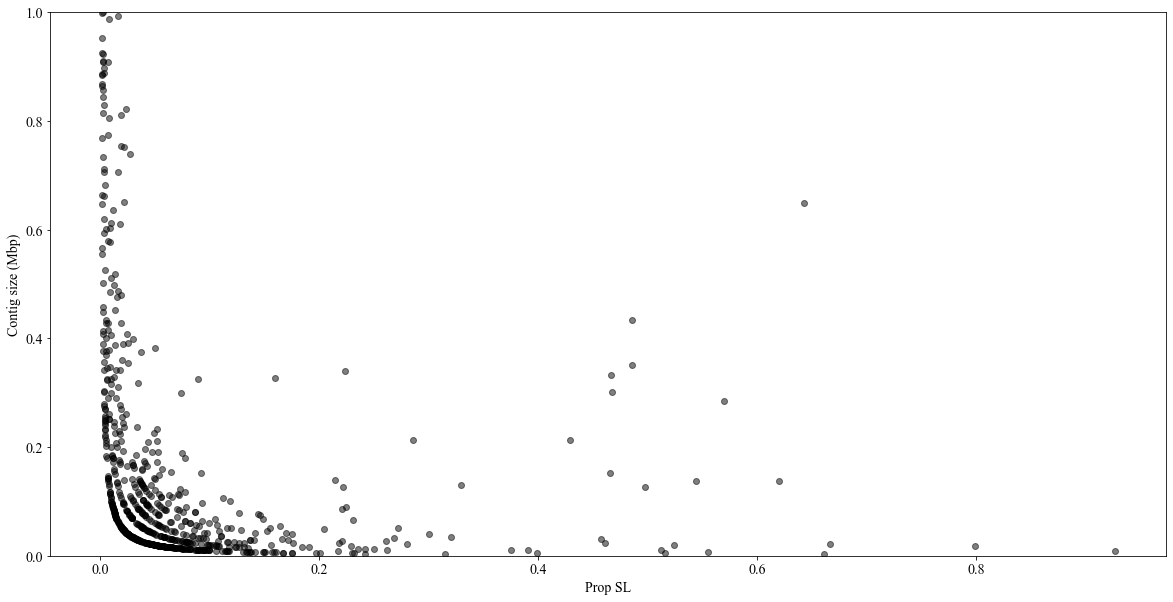

In [145]:
fig = plt.figure(figsize = (20,10))

for contig in sorted_prop_SL_dict:
    
    plt.scatter(sorted_prop_SL_dict[contig], lengths[contig]/1000000, color = "black", alpha = 0.5)
    
plt.xlabel("Prop SL")
plt.ylabel("Contig size (Mbp)")

plt.ylim(0,1)
plt.show()
    

### now for the Y contigs

In [147]:
## First count the number of bins in each contig that are sex specific
from collections import Counter
Y_contig_counts = Counter(["_".join(i.split("_")[:2]) for i in Y_spec_bins])

## Now get lengths
with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/contigs.bed") as cont_lengths:
    lengths = {}
    for line in cont_lengths:
        lengths[line.split()[0]] = int(line.split()[2])
        
## Now plot proportions
prop_YSL_dict = {}

for contig in Y_contig_counts:
    contig_length = lengths[contig]
    prop_SL = (Y_contig_counts[contig])*1000/contig_length
    
    prop_YSL_dict[contig] = prop_SL

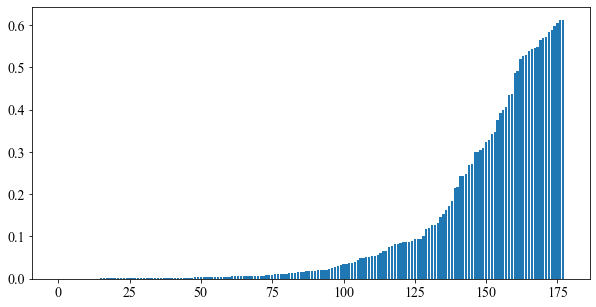

In [148]:
sorted_prop_YSL_dict = dict(sorted(prop_YSL_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize = (10,5))
plt.bar(range(len(sorted_prop_YSL_dict)), sorted_prop_YSL_dict.values())
plt.show()
    

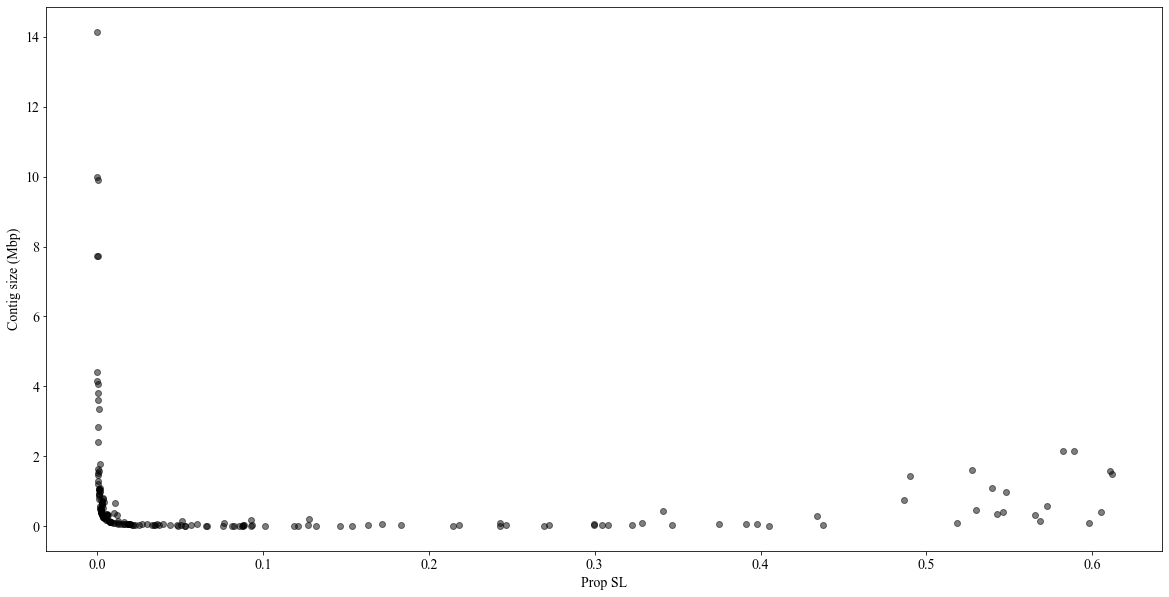

In [150]:
fig = plt.figure(figsize = (20,10))

for contig in sorted_prop_YSL_dict:
    
    plt.scatter(sorted_prop_YSL_dict[contig], lengths[contig]/1000000, color = "black", alpha = 0.5)
    
plt.xlabel("Prop SL")
plt.ylabel("Contig size (Mbp)")

#plt.ylim(0,1)
plt.show()
    

In [156]:
count = 0
for contig in contig_counts:
    if contig in Y_contig_counts:
        count += 1
        
print("There are %s contigs with X specific windows" % len(contig_counts))
print("There are %s contigs with Y specific windows" % len(Y_contig_counts))
print("There are %s contigs with both X and Y specific windows" % count)

There are 868 contigs with X specific windows
There are 178 contigs with Y specific windows
There are 94 contigs with both X and Y specific windows


So there are many X and Y specific bins. I think the best approach is to try to remove the rest of the Y specific contigs. However, there is no easy way to do this without arbitrarily setting a cut off, e.g. >20% of the contig is X specific. 

One useful approach may be to ask what percentage of the X or Y specific bins are represented in contigs with >20% of their length bing X/Y specific. Lets try some thresholds. 


### X specific bin usage

In [188]:
X_bin_count = 0
thresh = 0.7
for contig in prop_SL_dict:
    
    if prop_SL_dict[contig] >= thresh:
        
        X_bin_count += contig_counts[contig]
    
    
    
print("Threshold of %s incorporates %s out of %s X-specific bins (%s%%)" % (thresh, 
                                                                     X_bin_count, 
                                                                     np.sum(list(contig_counts.values())),
                                                                     np.round(X_bin_count/np.sum(list(contig_counts.values())),2)))


Threshold of 0.7 incorporates 16793 out of 23003 X-specific bins (0.73%)


### Y specific bin usage

In [195]:
Y_bin_count = 0
thresh = 0.5
for contig in prop_YSL_dict:
    
    if prop_YSL_dict[contig] >= thresh:
        
        Y_bin_count += Y_contig_counts[contig]
    
    
    
print("Threshold of %s incorporates %s out of %s X-specific bins (%s%%)" % (thresh, 
                                                                     Y_bin_count, 
                                                                     np.sum(list(Y_contig_counts.values())),
                                                                     np.round(Y_bin_count/np.sum(list(Y_contig_counts.values())),2)))


Threshold of 0.5 incorporates 7973 out of 9832 X-specific bins (0.81%)


## Testing the G parameter in SRY.

We ran tests of the G parameter for values of 27, 28, 29, 30, 35 and will compare that to an assembly with no SRY-removed reads. 

I have aligned data to all assemblies, and will now plot the depth per bin as above. 

## G27

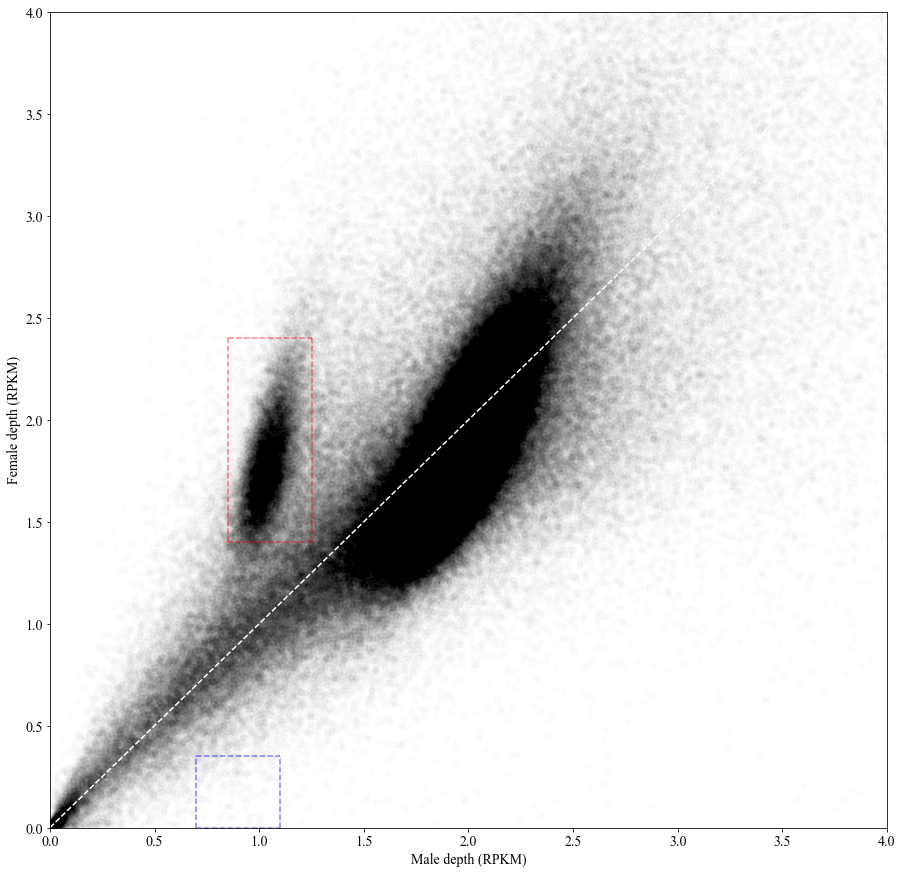

In [197]:
bin_depths_path_G27 = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/G27/Combined_depths.out"
M_F_bin_coverage(bin_depths_path_G27)

## G28_new

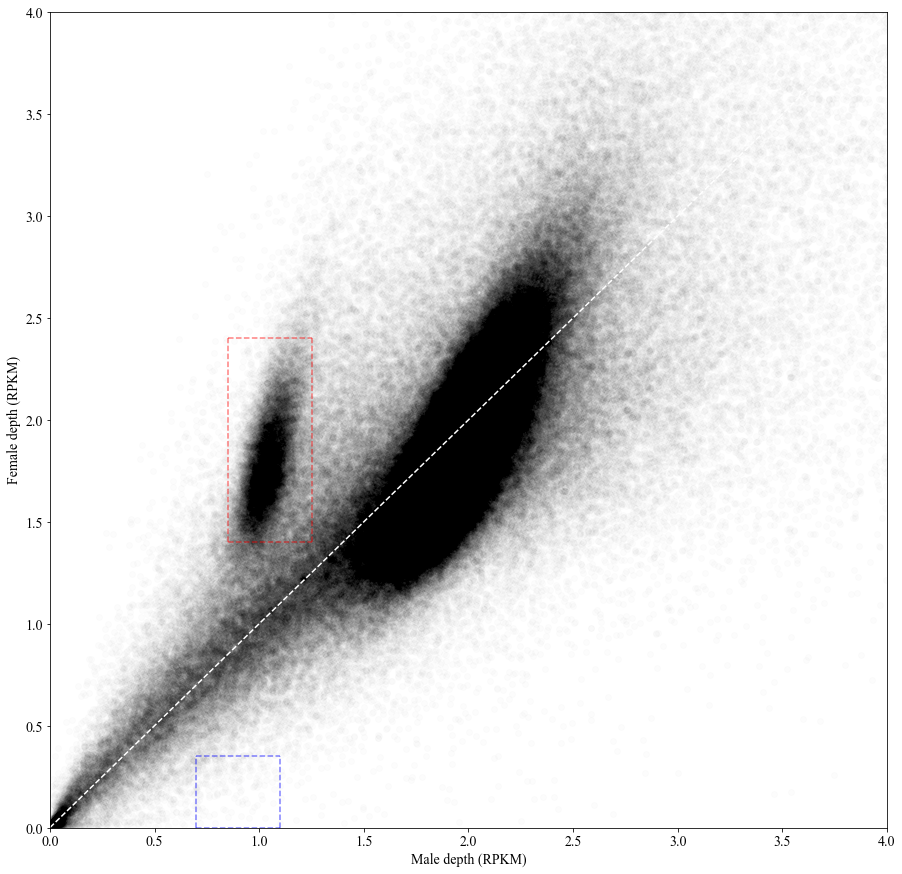

In [199]:
bin_depths_path_G28 = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/G28_new/Combined_depths.out"
M_F_bin_coverage(bin_depths_path_G28)

## G29

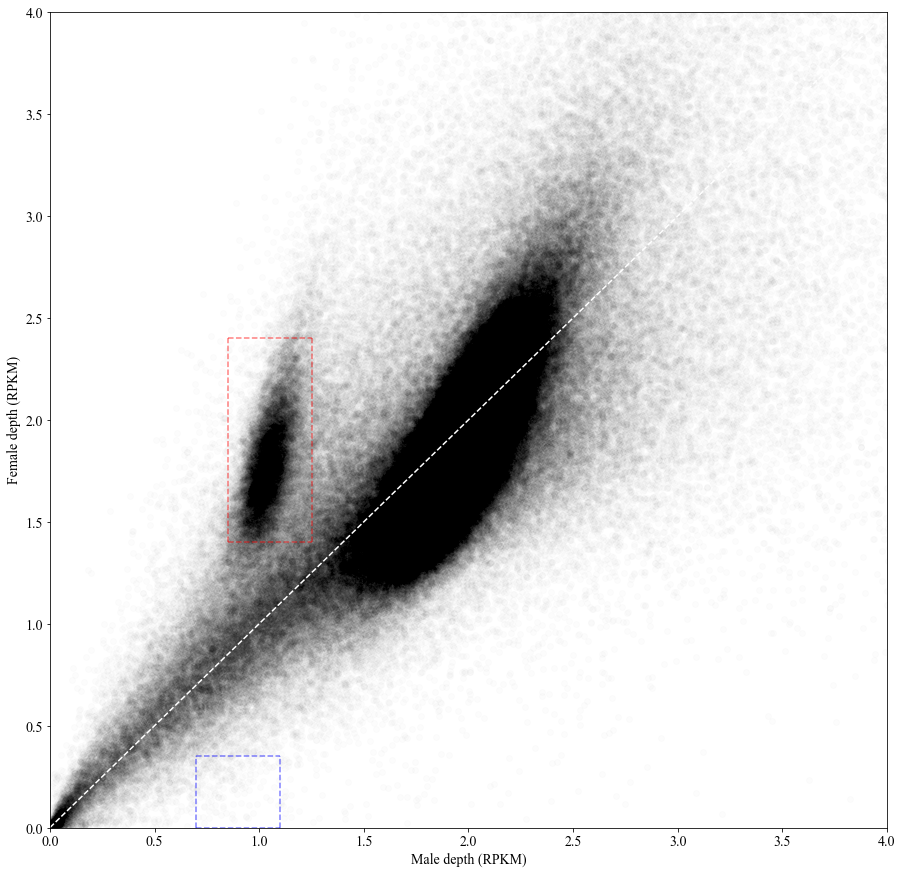

In [200]:
bin_depths_path_G29 = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/G29/Combined_depths.out"
M_F_bin_coverage(bin_depths_path_G29)

## G30

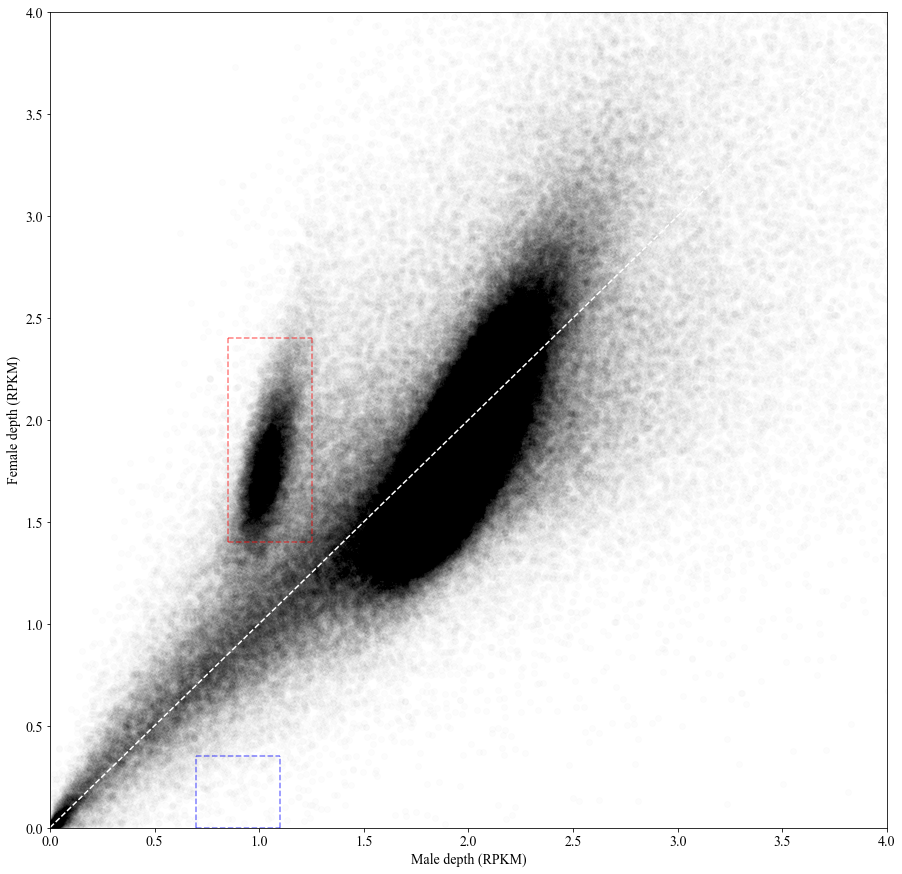

In [201]:
bin_depths_path_G30 = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/G30/Combined_depths.out"
M_F_bin_coverage(bin_depths_path_G30)

## G35

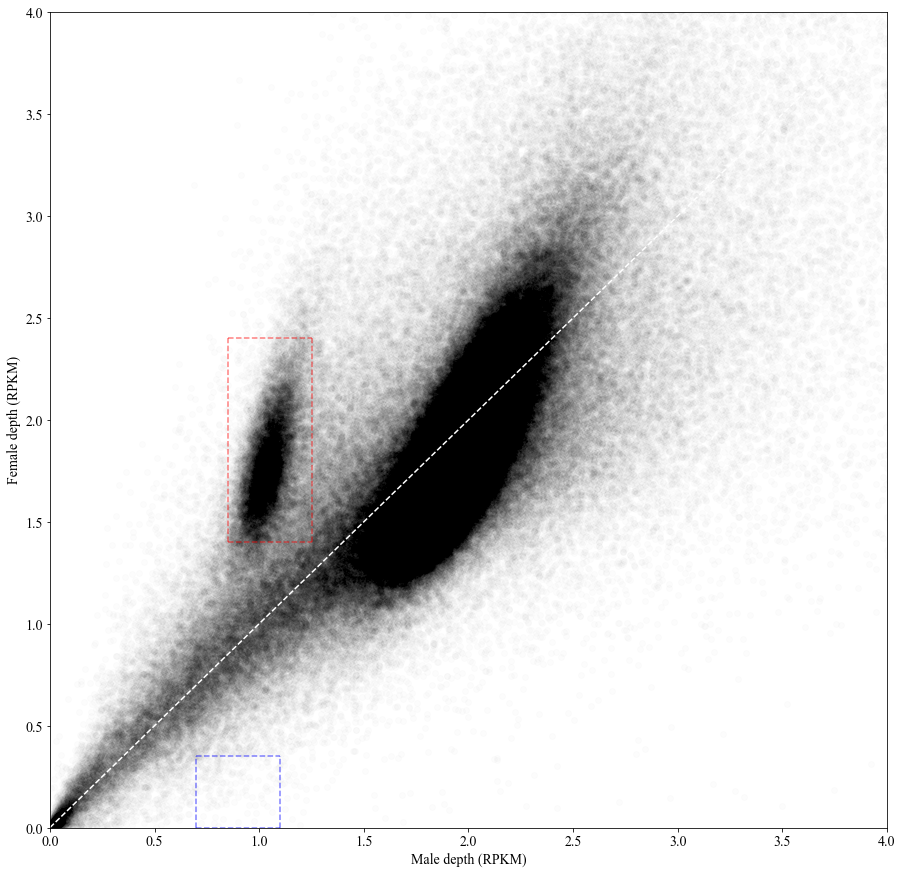

In [202]:
bin_depths_path_G35 = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/G35/Combined_depths.out"
M_F_bin_coverage(bin_depths_path_G35)

## all

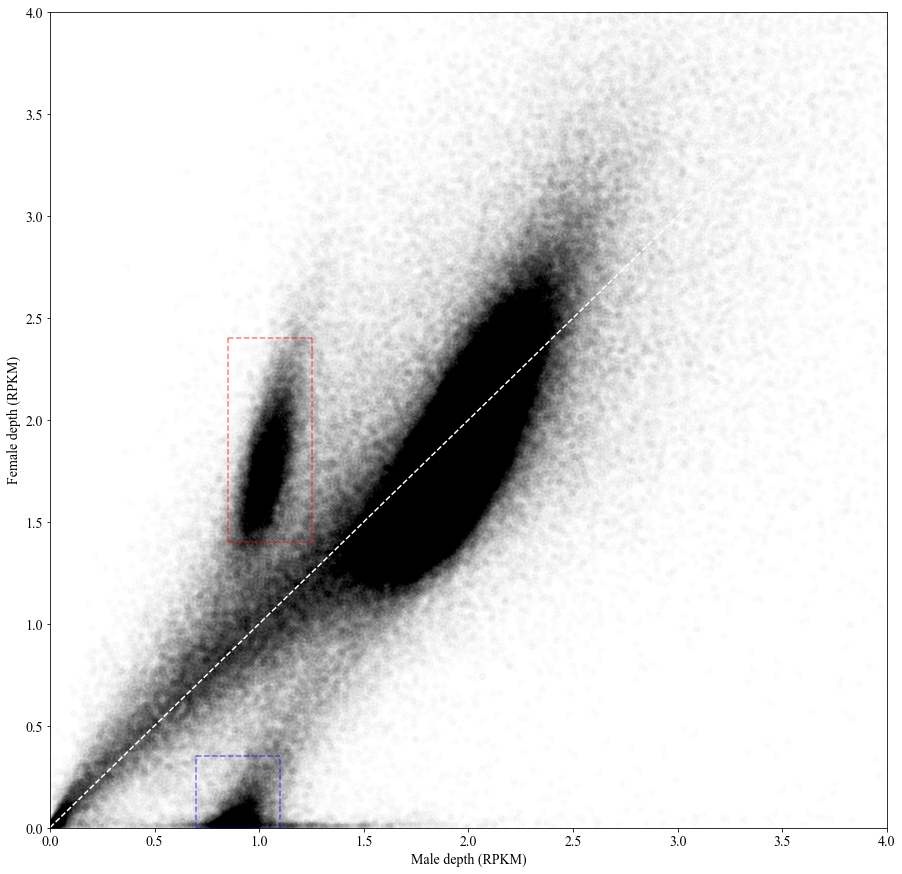

In [214]:
bin_depths_path_all = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/all/Combined_depths.out"
all_bins, all_male_avgs, all_female_avgs = M_F_bin_coverage(bin_depths_path_all)

## Finding male specific HiC reads. 

We used the SRY male specific kmer set to pull HiC reads with at least one Kmer match. Ideally these are Y specific HiC read pairs. To validate this, I aligned the putative male specific HiC read pairs to the "All" assembly, which I know from the plot above contains Y specific contigs. 

I expect to see these contigs with alignments and very few alignments to other contigs. . . lets see. 

I calculated RPKM depths again using deeptools 

### First, find ID of Y contigs

In [217]:
all_Y_spec_bins = []
for i in range(len(all_bins)):
    if 0.7 < all_male_avgs[i] < 2 and 0 < all_female_avgs[i] < 0.35:
        all_Y_spec_bins.append(bins[i])

In [277]:
all_X_spec_bins = []
for i in range(len(all_bins)):
    if 0.85 < all_male_avgs[i] < 1.25 and 1.4 < all_female_avgs[i] < 2.4:
        all_X_spec_bins.append(bins[i])

## Now plot the proportion of each contig that is made up of sex specific bins

### Y linked

In [221]:
## First count the number of bins in each contig that are sex specific
from collections import Counter
contig_counts = Counter(["_".join(i.split("_")[:2]) for i in Y_spec_bins])

## Now get lengths
with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/G28_old/contigs.bed") as cont_lengths:
    lengths = {}
    for line in cont_lengths:
        lengths[line.split()[0]] = int(line.split()[2])
        
## Now plot proportions
prop_SL_dict = {}

for contig in contig_counts:
    contig_length = lengths[contig]
    prop_SL = (contig_counts[contig])*1000/contig_length
    
    prop_SL_dict[contig] = prop_SL

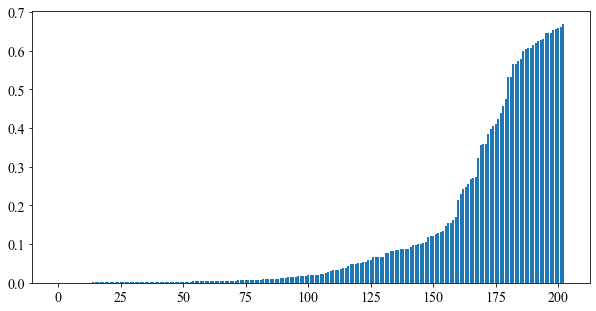

In [222]:
sorted_prop_SL_dict = dict(sorted(prop_SL_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize = (10,5))
plt.bar(range(len(sorted_prop_SL_dict)), sorted_prop_SL_dict.values())
plt.show()
    

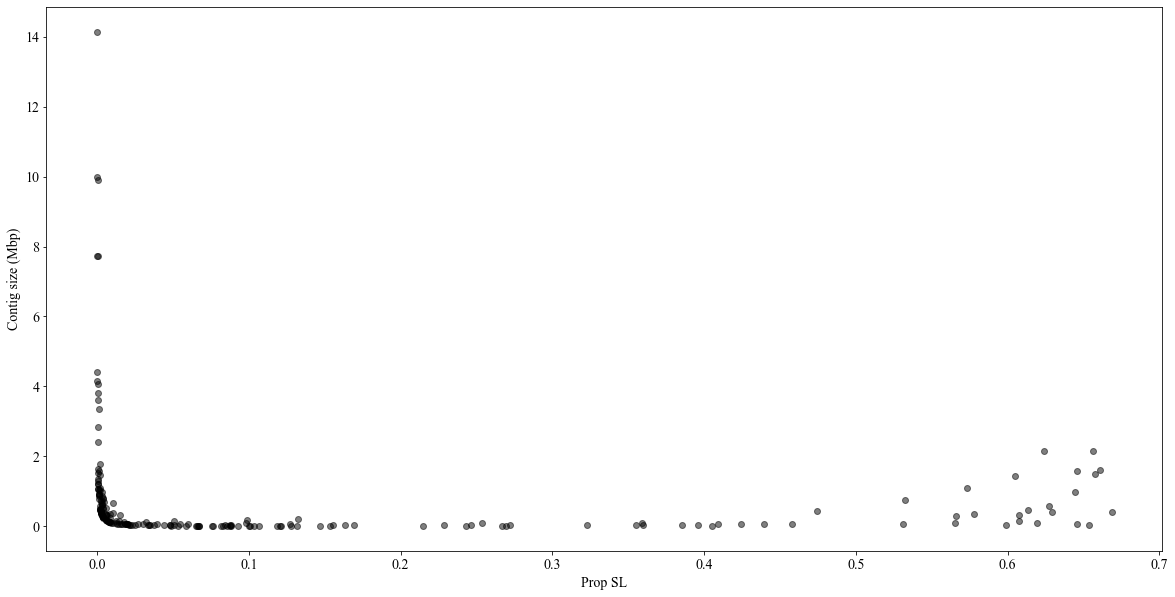

In [223]:
fig = plt.figure(figsize = (20,10))

for contig in sorted_prop_SL_dict:
    
    plt.scatter(sorted_prop_SL_dict[contig], lengths[contig]/1000000, color = "black", alpha = 0.5)
    
plt.xlabel("Prop SL")
plt.ylabel("Contig size (Mbp)")

plt.show()
    

Lets use contigs above 30% Y speific bins as our pool of Y specific contigs

In [275]:
Putative_Y_spec_contigs = []
for contig in sorted_prop_SL_dict:
    if sorted_prop_SL_dict[contig] > 0.1:
        Putative_Y_spec_contigs.append(contig)

### X linked

In [278]:
## First count the number of bins in each contig that are sex specific
from collections import Counter
contig_counts = Counter(["_".join(i.split("_")[:2]) for i in all_X_spec_bins])

## Now get lengths
with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/G28_old/contigs.bed") as cont_lengths:
    lengths = {}
    for line in cont_lengths:
        lengths[line.split()[0]] = int(line.split()[2])
        
## Now plot proportions
prop_XL_dict = {}

for contig in contig_counts:
    contig_length = lengths[contig]
    prop_SL = (contig_counts[contig])*1000/contig_length
    
    prop_XL_dict[contig] = prop_SL

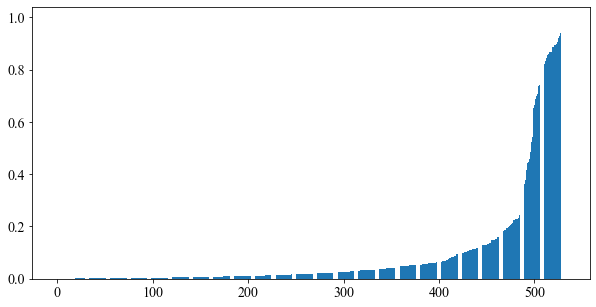

In [279]:
sorted_prop_XL_dict = dict(sorted(prop_XL_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize = (10,5))
plt.bar(range(len(sorted_prop_XL_dict)), sorted_prop_XL_dict.values())
plt.show()
    

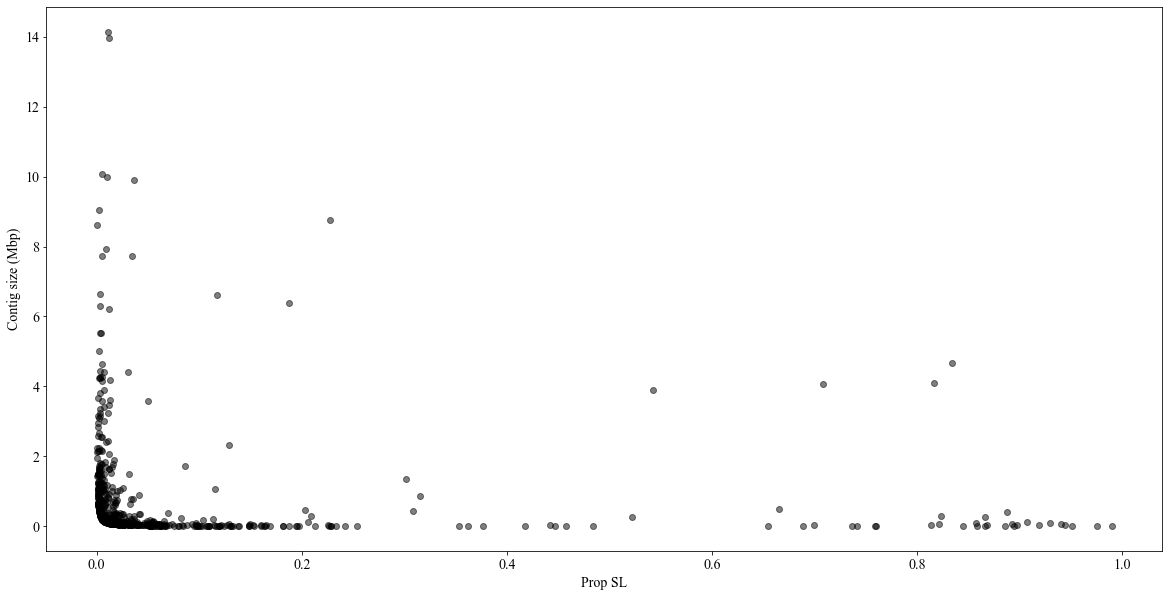

In [282]:
fig = plt.figure(figsize = (20,10))

for contig in sorted_prop_XL_dict:
    
    plt.scatter(sorted_prop_XL_dict[contig], lengths[contig]/1000000, color = "black", alpha = 0.5)
    
plt.xlabel("Prop SL")
plt.ylabel("Contig size (Mbp)")

plt.show()
    

In [283]:
Putative_X_spec_contigs = []
for contig in sorted_prop_XL_dict:
    if sorted_prop_XL_dict[contig] > 0.1:
        Putative_X_spec_contigs.append(contig)

### Now lets see how the HiC compares to the contigs identified by our read depth analysis

In [225]:
HiC_depths_path = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/HiC/M_spec_kmer_align/M_spec_align_depths.out"

In [247]:
HiC_contig_depth_dict = {}
all_depths = []

with open(HiC_depths_path) as HiC_depths:
    for line in HiC_depths:
        contigID = line.split()[0]
        binStart = line.split()[1]
        depth = float(line.split()[3])
        
        if contigID not in HiC_contig_depth_dict:
            HiC_contig_depth_dict[contigID] = []
            
        HiC_contig_depth_dict[contigID].append(depth)
        all_depths.append(depth)
    
HiC_contig_proportions = {} ## proportion of all HiC reads that align to each contig
    
total_RPKM = np.sum(all_depths)
    
for contig in HiC_contig_depth_dict:
    HiC_contig_proportions[contig] = np.sum(HiC_contig_depth_dict[contig])/total_RPKM
    
        

### Plotting sorted proportion of HiC reads per contig

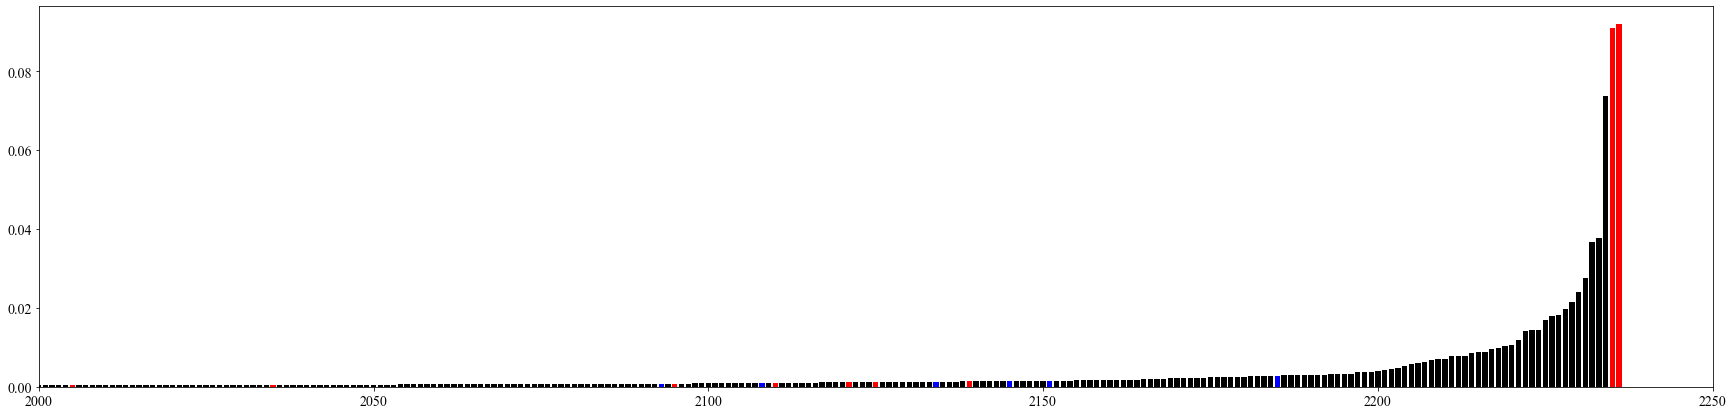

In [287]:
fig = plt.figure(figsize = (30,7))
pos = 0
cumul = 0

for contig in sorted_HiC_contig_proportions:
    
    if contig in Putative_Y_spec_contigs:
        coloUr = "red"
    elif contig in Putative_X_spec_contigs:
        coloUr = "blue"
    else:
        coloUr = "black"
    
    plt.bar(pos, sorted_HiC_contig_proportions[contig], color = coloUr)
        
    pos += 1

plt.xlim(2000,2250)
plt.show()
    
    
    

### Plotting the cumulative proportion of HiC reads aligning to each contig

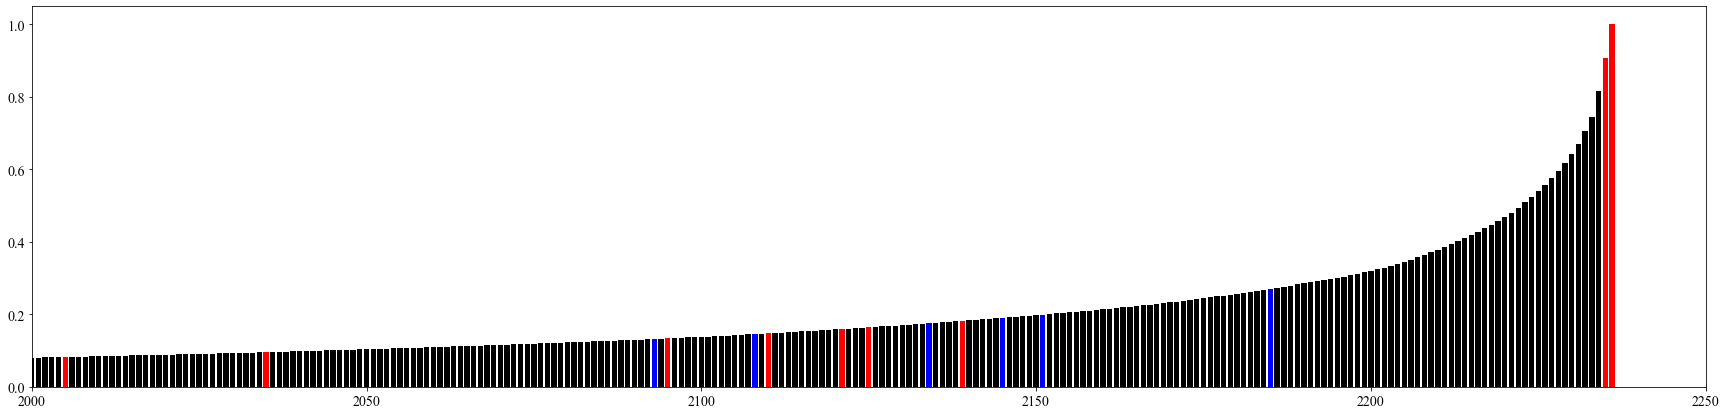

In [286]:
fig = plt.figure(figsize = (30,7))
pos = 0
cumul = 0

for contig in sorted_HiC_contig_proportions:
    
    if contig in Putative_Y_spec_contigs:
        coloUr = "red"
    elif contig in Putative_X_spec_contigs:
        coloUr = "blue"
    else:
        coloUr = "black"
    
    plt.bar(pos, sorted_HiC_contig_proportions[contig]+cumul, color = coloUr)
    
    cumul = cumul+sorted_HiC_contig_proportions[contig]
    
    pos += 1

plt.vlines(0.5, 2000, 2240)
plt.xlim(2000,2250)
plt.show()
    
    
    

So this is not as convincing as I'd expected. It might be that there are contigs that I did not do a good job of identifying as Y specific though, it would be interesting to see where the contigs are that are enriched for HiC reads on the depth comparison plots above. Lets try the top 10 HiC enriched contigs

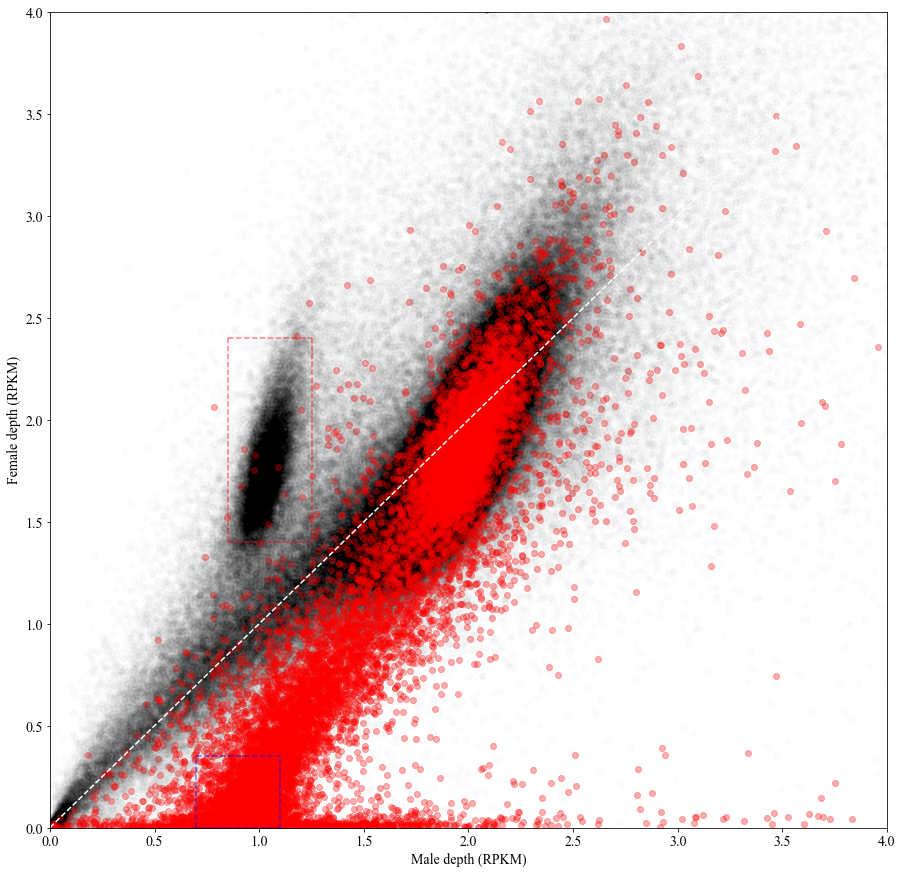

In [298]:
bin_depths_path_all = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/all/Combined_depths.out"
all_bins, all_male_avgs, all_female_avgs = M_F_bin_coverage(bin_depths_path_all, list(sorted_HiC_contig_proportions.keys())[-10:])

Ok, so this looks a bit more reassuring. There is a clear enrichment for the contigs which are putatively Y specific. It is likely that many of the contigs that are present in the main cluster of points in the centre are the same contig which contain Y specific bins. To view this even better would be to colour this by the number of HiC reads in each bin! 

In [365]:
def M_F_bin_coverage(bin_depths_path, colour_contigs = None, colour_bins = None, colour_map = "Oranges", colour_label = "HiC RPKM", myalpha = 0.3):
    
    from matplotlib import cm
    
    with open(bin_depths_path) as bin_depths:
    
    
        bin_dict = {}
        colour_bin_dict = {}

        M_indices = []
        F_indices = []

        for line in bin_depths:

            if line.startswith("CHROM"):
                samples = line.split()[3:]

                sample_index = 0

                for sample in samples:
                    if "_F" in sample:
                        F_indices.append(sample_index)
                    elif "_M" in sample:
                        M_indices.append(sample_index)

                    sample_index += 1

            else:
                contig = line.split()[0]
                stop = line.split()[2]
                mybin = "%s_%s" % (contig, stop)
                
                bin_dict[mybin] = {}
                bin_dict[mybin]["males"] = []
                bin_dict[mybin]["females"] = []

                data_fields = line.split()[3:]

                for index in range(0,34):
                    if index in M_indices:
                        bin_dict[mybin]["males"].append(float(data_fields[index]))
                    elif index in F_indices:
                        bin_dict[mybin]["females"].append(float(data_fields[index]))
                        
                        
                if colour_contigs:
                    
                    if contig in colour_contigs:
                    
                        colour_bin_dict[mybin] = {}
                        colour_bin_dict[mybin]["males"] = []
                        colour_bin_dict[mybin]["females"] = []

                        data_fields = line.split()[3:]

                        for index in range(0,34):
                            if index in M_indices:
                                colour_bin_dict[mybin]["males"].append(float(data_fields[index]))
                            elif index in F_indices:
                                colour_bin_dict[mybin]["females"].append(float(data_fields[index]))

                        
        bins = []                    
        male_avgs = []
        female_avgs = []


        for mybin in bin_dict:
            bins.append(mybin)
            male_avgs.append(np.mean(bin_dict[mybin]["males"]))
            female_avgs.append(np.mean(bin_dict[mybin]["females"]))

        ## Colour by a list of contigs
        
        if colour_contigs:
            colour_male_avgs = []
            colour_female_avgs = []
            
        if colour_contigs:
            for mybin in colour_bin_dict:
                colour_male_avgs.append(np.mean(bin_dict[mybin]["males"]))
                colour_female_avgs.append(np.mean(bin_dict[mybin]["females"]))

        ## colour by a list of bins
        
        if colour_bins:
            colour_male_avgs_bins = []
            colour_female_avgs_bins = []
            colour_by_value = []
                        
            colour_bins_sorted = dict(sorted(colour_bins.items(), key=lambda item: item[1]))
            
            for mybin in colour_bins_sorted:
                if mybin in bin_dict:
                    colour_male_avgs_bins.append(np.mean(bin_dict[mybin]["males"]))
                    colour_female_avgs_bins.append(np.mean(bin_dict[mybin]["females"]))
                    colour_by_value.append(colour_bins[mybin])
                
                
        plt.figure(figsize = (15,15))

        #plt.scatter(male_avgs, female_avgs, color = "black", alpha = 0.01)
        
        if colour_contigs:
            plt.scatter(colour_male_avgs, colour_female_avgs, color = "red", alpha = 0.3)
            
        if colour_bins:
            
            plt.scatter(colour_male_avgs_bins, colour_female_avgs_bins, c = colour_by_value, cmap = colour_map, alpha = myalpha)

        plt.plot(range(0,10), range(0,10), color = "white", linestyle = "dashed")

        ## setting out bins for filtering
        #plt.vlines(0.85, 1.4, 2.4, linestyle = "dashed", color = "red", alpha = 0.5)
        #plt.vlines(1.25, 1.4, 2.4, linestyle = "dashed", color = "red", alpha = 0.5)
        #plt.hlines(1.4, 0.85, 1.25, linestyle = "dashed", color = "red", alpha = 0.5)
        #plt.hlines(2.4, 0.85, 1.25, linestyle = "dashed", color = "red", alpha = 0.5)

        #plt.vlines(0.7, 0, 0.35, linestyle = "dashed", color = "blue", alpha = 0.5)
        #plt.vlines(1.1, 0, 0.35, linestyle = "dashed", color = "blue", alpha = 0.5)
        #plt.hlines(0, 0.7, 1.1, linestyle = "dashed", color = "blue", alpha = 0.5)
        #plt.hlines(0.35, 0.7, 1.1, linestyle = "dashed", color = "blue", alpha = 0.5)

        plt.xlim(0,4)
        plt.ylim(0,4)

        plt.xlabel("Male depth (RPKM)")
        plt.ylabel("Female depth (RPKM)")

        plt.colorbar(label=colour_label, orientation="vertical")
        plt.show()
        
        return bins, male_avgs, female_avgs
    

In [225]:
HiC_depths_path = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/HiC/M_spec_kmer_align/M_spec_align_depths.out"

In [334]:
HiC_bin_depth_dict = {}
all_depths = []

with open(HiC_depths_path) as HiC_depths:
    for line in HiC_depths:
        
        depth = float(line.split()[3])
        
        contig = line.split()[0]
        stop = line.split()[2]
        mybin = "%s_%s" % (contig, stop)
                
        HiC_bin_depth_dict[mybin] = depth
        
        

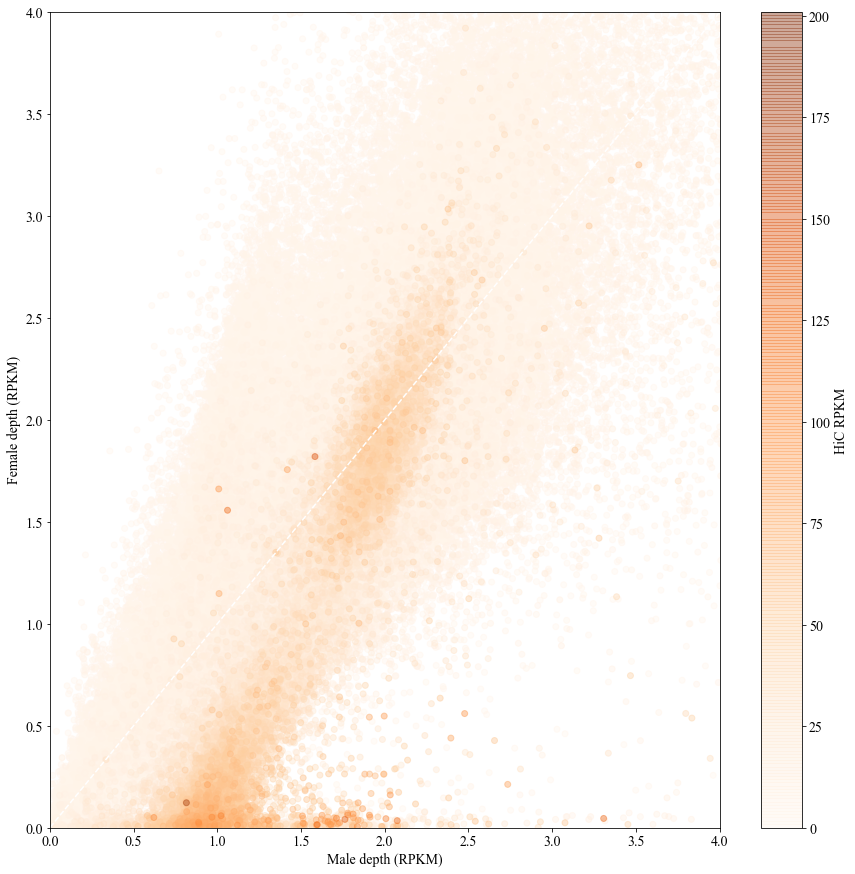

In [376]:
bin_depths_path_all = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/all/Combined_depths.out"
all_bins, all_male_avgs, all_female_avgs = M_F_bin_coverage(bin_depths_path_all, colour_map = "Oranges", colour_bins= HiC_bin_depth_dict, myalpha = 0.4)

Ok so this is much the same picture. Though there are still bins with no male / female depth difference, these could be falsely removed reads, or they could be reads in regions which have male specific SNPs but no major sequence divergence and so are collapsed during assembly. 